In [13]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange 

from flow.nvp_y import RealNVP

def convert(x):
    return torch.as_tensor(x).float()

Data: X.shape=(20000, 2) Y.shape=(20000, 2)


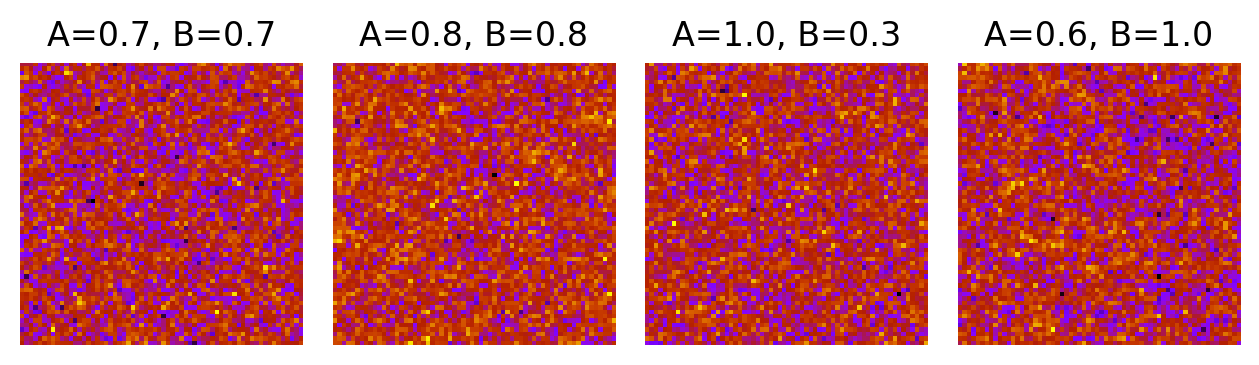

In [14]:
data_dir = "data/"

field_type = "G"
parameter_names = ["A", "B"]

D = np.load(os.path.join(data_dir, field_type + "_fields.npy"))
X = np.load(os.path.join(data_dir, field_type + "_nn_summaries.npy"))
Y = np.load(os.path.join(data_dir, "field_parameters.npy"))

X_ = np.load(os.path.join(data_dir, field_type + "_nn_summary_data.npy"))

print(f"Data: {X.shape=} {Y.shape=}")

fig, axs = plt.subplots(1, 4, dpi=200)
for i, ax in enumerate(axs):
    A, B = Y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(D[i], cmap="gnuplot")
    ax.axis("off")
# plt.colorbar(im)
plt.tight_layout()
plt.show()

In [15]:
# Data
data_dim = Y.shape[-1] 
parameter_dim = Y.shape[-1]
# Model
H = 256 # Hidden size
L = 3 # Layers
# Optimisation
lr = 3e-4
n_steps = 2_000
batch_size = 400

In [ ]:
# Data
data_dim = Y.shape[-1] 
parameter_dim = Y.shape[-1]
# Model
H = 256 # Hidden size
L = 3 # Layers
# Optimisation
lr = 3e-4
n_steps = 2_000
batch_size = 400

In [16]:
net_s = lambda: nn.Sequential(
    nn.Linear(data_dim + parameter_dim, H), 
    nn.Tanh(),
    nn.Linear(H, H), 
    nn.Tanh(),
    nn.Linear(H, data_dim), 
    nn.Tanh()
)
net_t = lambda: nn.Sequential(
    nn.Linear(data_dim + parameter_dim, H), 
    nn.Tanh(), 
    nn.Linear(H, H), 
    nn.Tanh(), 
    nn.Linear(H, data_dim)
)

masks = torch.stack([torch.arange(0, data_dim).float() % 2] * 3)

prior = td.MultivariateNormal(torch.zeros(data_dim), torch.eye(data_dim))

flow = RealNVP(net_s, net_t, masks, prior)

In [17]:
def get_data(n):
    ix = np.random.randint(len(X), size=(n,))
    return convert(X[ix]), convert(Y[ix])

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

losses = []
with trange(n_steps) as steps:
    for s in steps:
        x, y = get_data(batch_size)

        loss = -flow.log_prob(y, x).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        steps.set_postfix(loss=f"{loss:.3E}")

  0%|          | 0/2000 [00:00<?, ?it/s]

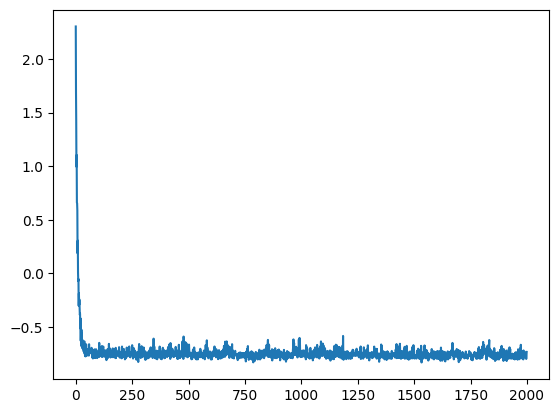

In [18]:
plt.figure()
plt.plot(losses)
plt.show()

(20000, 2)


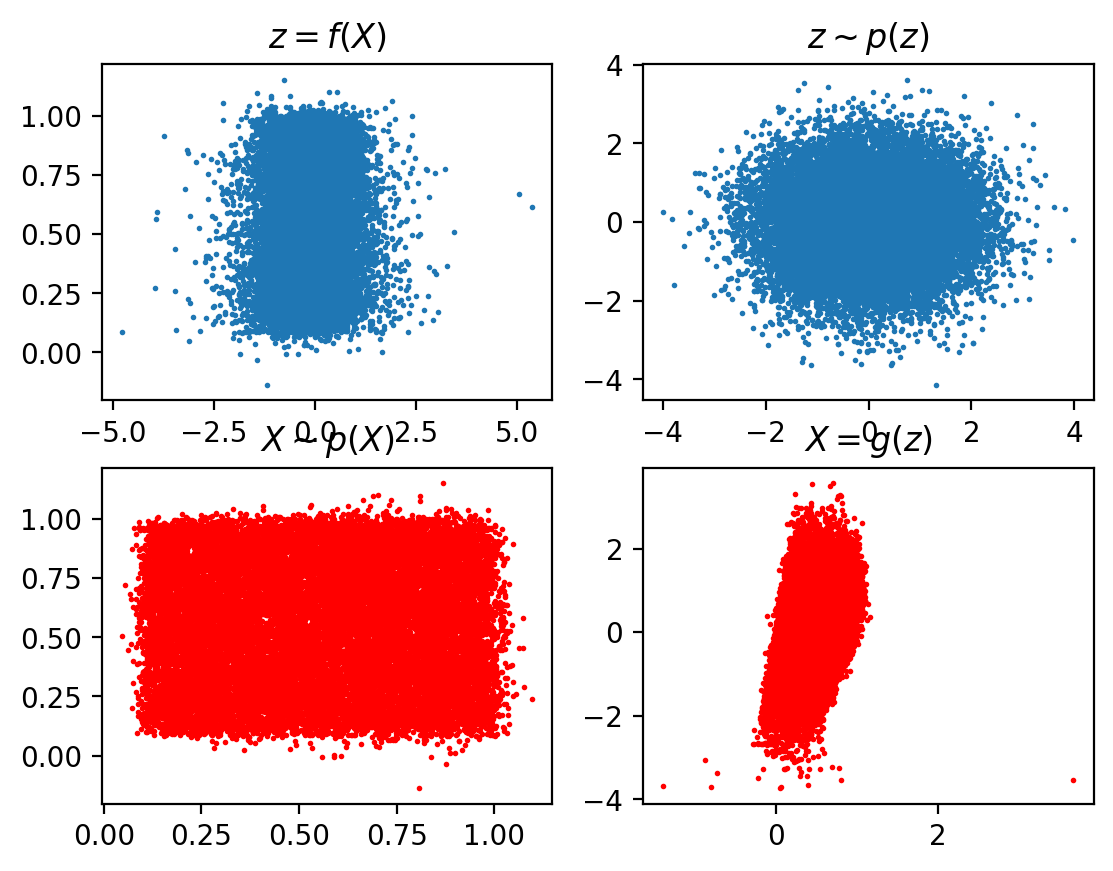

In [19]:
plt.figure(dpi=200)

z = flow.forward(convert(X), convert(Y))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z = f(X)$')

z = prior.sample((len(X),))
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
plt.scatter(X[:, 0], X[:, 1], c='r', s=1.)
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(len(X), convert(Y)).detach().numpy()
print(x.shape)
plt.scatter(x[:, 0], x[:, 1], c='r', s=1.)
plt.title(r'$X = g(z)$')

plt.show()

In [20]:
(400_000 - 4096 - 2) / (400_000 - 1)

0.989757474393686

In [25]:
alpha = np.load(os.path.join(data_dir, field_type + "_alpha.npy"))
derivatives = np.load(os.path.join(data_dir, field_type + "_derivatives.npy"))
mean = np.load(os.path.join(data_dir, field_type + "_mean.npy"))
covariance = np.load(os.path.join(data_dir, field_type + "_covariance.npy"))
precision = np.linalg.inv(covariance) # Assuming H ~ 1

# Is this right? Forecast assuming linear model and Gaussian errors
Finv = np.linalg.inv(np.linalg.multi_dot([derivatives, precision, derivatives.T]))

In [29]:
n_posterior_samples = 40_000

In [30]:
Finv = np.load(os.path.join(data_dir, field_type + "_Finv.npy"))

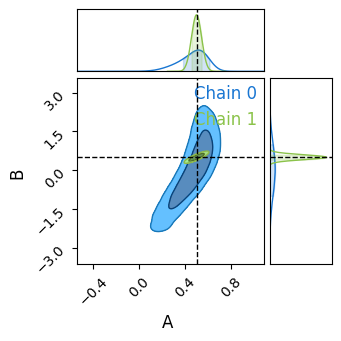

In [31]:
from chainconsumer import ChainConsumer 

posterior_samples = flow.sample(n_posterior_samples, torch.tile(convert(X_), (n_posterior_samples, 1)))
posterior_samples = posterior_samples.detach().numpy()

c = ChainConsumer()
c.add_chain(posterior_samples, parameters=parameter_names)
c.add_covariance(alpha, Finv, parameters=parameter_names)
fig = c.plotter.plot(truth=alpha)

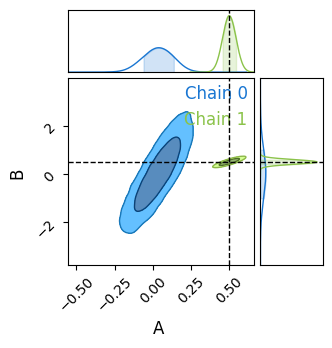

In [35]:
mean = np.load(os.path.join(data_dir, field_type + "_nn_summary_mean.npy"))

posterior_samples = flow.sample(n_posterior_samples, torch.tile(convert(mean.flatten()[None, :]), (n_posterior_samples, 1)))
posterior_samples = posterior_samples.detach().numpy()

c = ChainConsumer()
c.add_chain(posterior_samples, parameters=parameter_names)
c.add_covariance(alpha, Finv, parameters=parameter_names)
fig = c.plotter.plot(truth=alpha)